# Structured Autoencoder: 2D Content + 6D Transform

**Minimal Training Notebook - Updated for Corrected Architecture**

- **2D Content Latent**: Digit identity/shape clustering ✅ IMPROVED!
- **6D Transform Latent**: Spatial transformations  
- **Cloud Ready**: CUDA/CPU optimization
- **Simplified Loss**: Uses new affine+KL loss function
- **Explicit Imports**: Clear module references (structured_2d6d_autoencoder, affine_autoencoder_shared)

## 🎯 **CORRECTED ARCHITECTURE (v2):**
1. **Input → Encoder → 2D Content Latent**
2. **2D Content Latent → Decoder → Clean Canonical Digit** ⭐ KEY CHANGE
3. **Input → Transform Encoder → 6D Affine Parameters**
4. **Apply Affine Transform to Clean Digit → Final Output**
5. **Loss: Compare Final Output to Original Input**

### Expected Improvements:
- **Much better digit clustering** in 2D latent space
- **Clean canonical digits** from decoder (before transformation)
- **More interpretable latent representations**

## 🔄 Architecture Comparison

### ❌ **OLD (Incorrect) Architecture:**
- Decoder input: `content_latent + transform_latent` (8D)
- Transform parameters fed INTO decoder
- Result: Poor digit separation, confusing latent space

### ✅ **NEW (Corrected) Architecture:**
- Decoder input: `content_latent` only (2D)
- Affine transformation applied AFTER decoder
- Result: Better digit clustering, interpretable clean digits

This is a fundamental architectural fix that should dramatically improve the quality of the 2D content latent space!

In [19]:
import torch
# Explicit imports from modular structure
import structured_2d6d_autoencoder as s2d6d
import affine_autoencoder_shared as shared

# 🚀 CONFIG - Updated for simplified loss
CONFIG = {
    'content_latent_dim': 2, 'transform_latent_dim': 6, 'total_latent_dim': 8,
    'epochs': 40, 'learning_rate': 1e-3, 'batch_size_train': 256, 'batch_size_test': 128,
    'alpha': 1.0,  # Affine loss weight
    'beta': 0.001,  # KL divergence weight (reduced for 2D content latent)
    'force_cuda': True, 'mixed_precision': True, 'gradient_clip': 1.0,
    'pin_memory': True, 'num_workers': 4, 'weight_decay': 1e-5,
    'lr_scheduler': True, 'early_stopping': True, 'patience': 10,
    'data_dir': '../data', 'save_dir': './', 'checkpoint_freq': 10
}

In [20]:
# 🌩️ SETUP - Using shared utilities with explicit module reference
device = shared.get_cloud_device(CONFIG)
scaler = torch.cuda.amp.GradScaler() if CONFIG['mixed_precision'] and device.type == 'cuda' else None
train_loader, test_loader = shared.get_cloud_mnist_loaders(**{k: v for k, v in CONFIG.items() if k in ['batch_size_train', 'batch_size_test', 'data_dir', 'pin_memory', 'num_workers']})

🚀 Cloud CUDA device: GRID A100X-8C
💾 GPU Memory: 8.6GB
📊 Train batches: 235, Test batches: 79


/tmp/ipykernel_15618/1759643369.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CONFIG['mixed_precision'] and device.type == 'cuda' else None


In [21]:
# 🏗️ MODEL - Using structured_2d6d_autoencoder module explicitly
model = s2d6d.StructuredAffineInvariantAutoEncoder(
    content_dim=CONFIG['content_latent_dim'],
    transform_dim=CONFIG['transform_latent_dim']
).to(device)

In [ ]:
# 📂 OPTIONAL: LOAD EXISTING MODEL (comment out to train new)
# shared.list_saved_models()  # List available models (from affine_autoencoder_shared)
# model, CONFIG, device = shared.load_model_cloud("structured_model_YYYYMMDD_HHMMSS.pth")
# Note: Use shared.* functions from affine_autoencoder_shared module
# 
# 🚨 IMPORTANT: This model uses the CORRECTED architecture where:
# - Decoder takes ONLY content latent (2D), not content+transform (8D)
# - Affine transformation is applied AFTER decoder output
# - Model returns: (input_x, content_latent, transform_latent, unused, clean_reconstruction, content_mu, content_logvar, final_reconstruction)

In [ ]:
# 🚀 TRAIN - Using simplified affine+KL loss from structured_2d6d_autoencoder
# ✅ This training function has been updated to work with the corrected architecture
print("🎯 Training with CORRECTED ARCHITECTURE:")
print("  - Decoder takes ONLY 2D content latent")
print("  - Affine transform applied AFTER decoder output")
print("  - Should result in better digit clustering!")
print()

losses_dict = s2d6d.train_structured_autoencoder_simplified(model, train_loader, test_loader, device, CONFIG, scaler)

Epoch 1: 100%|██████████| 235/235 [00:03<00:00, 71.23it/s]


Epoch 1: Train=0.735695, Test=0.642933, Recon=0.735555, KL=0.139998


Epoch 2: 100%|██████████| 235/235 [00:03<00:00, 74.96it/s]


Epoch 2: Train=0.570583, Test=0.546715, Recon=0.569174, KL=1.408708


Epoch 3: 100%|██████████| 235/235 [00:03<00:00, 74.90it/s]


Epoch 3: Train=0.532741, Test=0.531330, Recon=0.530723, KL=2.018443


Epoch 4: 100%|██████████| 235/235 [00:03<00:00, 75.06it/s]


Epoch 4: Train=0.522940, Test=0.526779, Recon=0.520187, KL=2.753135


Epoch 5: 100%|██████████| 235/235 [00:03<00:00, 73.39it/s]


Epoch 5: Train=0.518697, Test=0.524517, Recon=0.515863, KL=2.834069


Epoch 6: 100%|██████████| 235/235 [00:03<00:00, 72.83it/s]


Epoch 6: Train=0.515885, Test=0.521267, Recon=0.513029, KL=2.856128


Epoch 7: 100%|██████████| 235/235 [00:03<00:00, 73.86it/s]


Epoch 7: Train=0.514353, Test=0.520003, Recon=0.511515, KL=2.837626


Epoch 8: 100%|██████████| 235/235 [00:03<00:00, 75.34it/s]


Epoch 8: Train=0.513240, Test=0.521336, Recon=0.510428, KL=2.812287


Epoch 9: 100%|██████████| 235/235 [00:03<00:00, 74.03it/s]


Epoch 9: Train=0.511413, Test=0.518243, Recon=0.508607, KL=2.805642


Epoch 10: 100%|██████████| 235/235 [00:03<00:00, 75.29it/s]


Epoch 10: Train=0.510706, Test=0.517329, Recon=0.507917, KL=2.788963


Epoch 11: 100%|██████████| 235/235 [00:03<00:00, 75.87it/s]


Epoch 11: Train=0.509665, Test=0.516769, Recon=0.506904, KL=2.761057


Epoch 12: 100%|██████████| 235/235 [00:03<00:00, 74.98it/s]


Epoch 12: Train=0.509528, Test=0.518734, Recon=0.506794, KL=2.734285


Epoch 13: 100%|██████████| 235/235 [00:03<00:00, 73.75it/s]


Epoch 13: Train=0.508601, Test=0.515940, Recon=0.505882, KL=2.718682


Epoch 14: 100%|██████████| 235/235 [00:03<00:00, 73.72it/s]


Epoch 14: Train=0.507721, Test=0.515031, Recon=0.505027, KL=2.693566


Epoch 15: 100%|██████████| 235/235 [00:03<00:00, 74.29it/s]


Epoch 15: Train=0.507524, Test=0.515392, Recon=0.504832, KL=2.691964


Epoch 16: 100%|██████████| 235/235 [00:03<00:00, 73.62it/s]


Epoch 16: Train=0.506880, Test=0.514748, Recon=0.504223, KL=2.656580


Epoch 17: 100%|██████████| 235/235 [00:03<00:00, 73.29it/s]


Epoch 17: Train=0.506398, Test=0.515357, Recon=0.503743, KL=2.655081


Epoch 18: 100%|██████████| 235/235 [00:03<00:00, 74.23it/s]


Epoch 18: Train=0.506426, Test=0.514075, Recon=0.503802, KL=2.623395


Epoch 19: 100%|██████████| 235/235 [00:03<00:00, 75.53it/s]


Epoch 19: Train=0.505634, Test=0.514168, Recon=0.503009, KL=2.625861


Epoch 20: 100%|██████████| 235/235 [00:03<00:00, 74.74it/s]


Epoch 20: Train=0.505464, Test=0.514256, Recon=0.502878, KL=2.585718


Epoch 21: 100%|██████████| 235/235 [00:03<00:00, 73.72it/s]


Epoch 21: Train=0.505040, Test=0.513237, Recon=0.502472, KL=2.567730


Epoch 22: 100%|██████████| 235/235 [00:03<00:00, 74.29it/s]


Epoch 22: Train=0.504661, Test=0.513050, Recon=0.502107, KL=2.554443


Epoch 23: 100%|██████████| 235/235 [00:03<00:00, 73.93it/s]


Epoch 23: Train=0.504368, Test=0.514713, Recon=0.501814, KL=2.553454


Epoch 24: 100%|██████████| 235/235 [00:03<00:00, 74.40it/s]


Epoch 24: Train=0.504169, Test=0.512678, Recon=0.501638, KL=2.530800


Epoch 25: 100%|██████████| 235/235 [00:03<00:00, 73.61it/s]


Epoch 25: Train=0.503982, Test=0.512788, Recon=0.501465, KL=2.516823


Epoch 26: 100%|██████████| 235/235 [00:03<00:00, 74.61it/s]


Epoch 26: Train=0.503624, Test=0.512399, Recon=0.501104, KL=2.520385


Epoch 27: 100%|██████████| 235/235 [00:03<00:00, 74.16it/s]


Epoch 27: Train=0.503632, Test=0.513196, Recon=0.501139, KL=2.493025


Epoch 28: 100%|██████████| 235/235 [00:03<00:00, 75.11it/s]


Epoch 28: Train=0.503266, Test=0.512885, Recon=0.500786, KL=2.479091


Epoch 29: 100%|██████████| 235/235 [00:03<00:00, 74.47it/s]


Epoch 29: Train=0.503241, Test=0.512532, Recon=0.500768, KL=2.473584


Epoch 30: 100%|██████████| 235/235 [00:03<00:00, 74.47it/s]


Epoch 30: Train=0.502816, Test=0.511436, Recon=0.500350, KL=2.465572


Epoch 31: 100%|██████████| 235/235 [00:03<00:00, 75.57it/s]


Epoch 31: Train=0.502959, Test=0.511381, Recon=0.500508, KL=2.451392


Epoch 32: 100%|██████████| 235/235 [00:03<00:00, 74.54it/s]


Epoch 32: Train=0.502681, Test=0.513924, Recon=0.500232, KL=2.449177


Epoch 33: 100%|██████████| 235/235 [00:03<00:00, 75.43it/s]


Epoch 33: Train=0.502535, Test=0.511616, Recon=0.500117, KL=2.418655


Epoch 34: 100%|██████████| 235/235 [00:03<00:00, 76.59it/s]


Epoch 34: Train=0.502431, Test=0.511831, Recon=0.500010, KL=2.421119


Epoch 35: 100%|██████████| 235/235 [00:03<00:00, 74.24it/s]


Epoch 35: Train=0.502196, Test=0.511373, Recon=0.499786, KL=2.410082


Epoch 36: 100%|██████████| 235/235 [00:03<00:00, 74.97it/s]


Epoch 36: Train=0.502224, Test=0.511587, Recon=0.499815, KL=2.408685


Epoch 37: 100%|██████████| 235/235 [00:03<00:00, 76.38it/s]


Epoch 37: Train=0.501949, Test=0.510806, Recon=0.499545, KL=2.404551


Epoch 38: 100%|██████████| 235/235 [00:03<00:00, 73.54it/s]


Epoch 38: Train=0.502014, Test=0.511627, Recon=0.499622, KL=2.391386


Epoch 39: 100%|██████████| 235/235 [00:03<00:00, 72.71it/s]


Epoch 39: Train=0.501772, Test=0.511797, Recon=0.499376, KL=2.395818


Epoch 40: 100%|██████████| 235/235 [00:03<00:00, 75.41it/s]


Epoch 40: Train=0.501677, Test=0.510833, Recon=0.499295, KL=2.381558


/home/exouser/Documents/adversAE/adversae/vae_training/affine/structured_2d6d_autoencoder.py:456: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/home/exouser/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


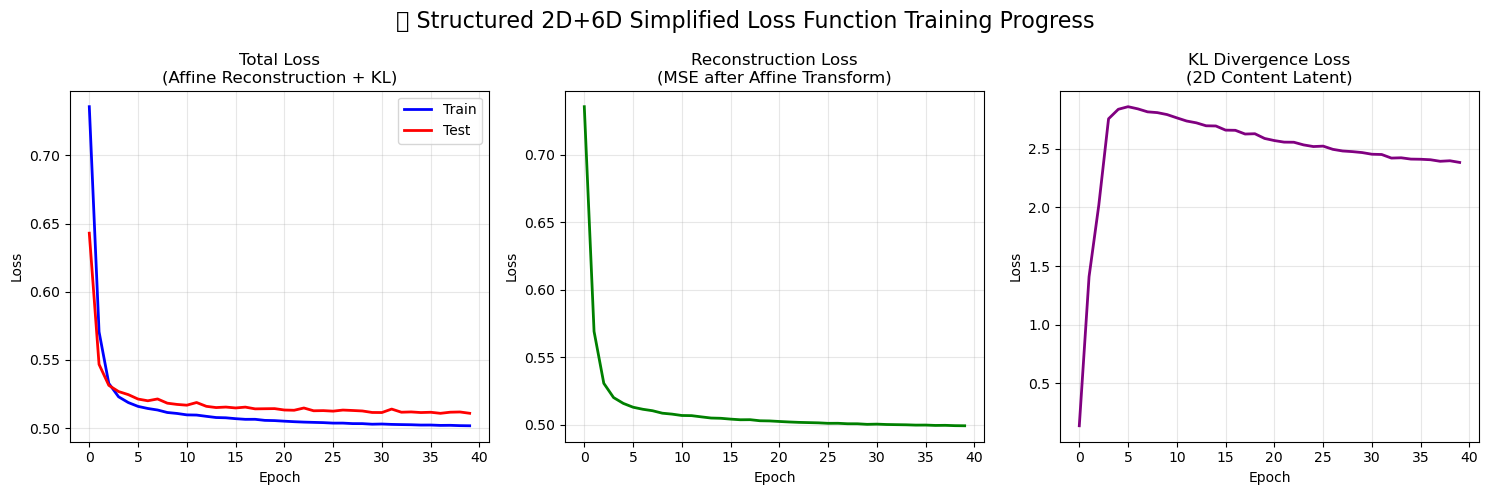


📊 Final Loss Values:
  Total Train Loss: 0.501677
  Total Test Loss: 0.510833
  Reconstruction Loss: 0.499295
  KL Divergence Loss: 2.381558


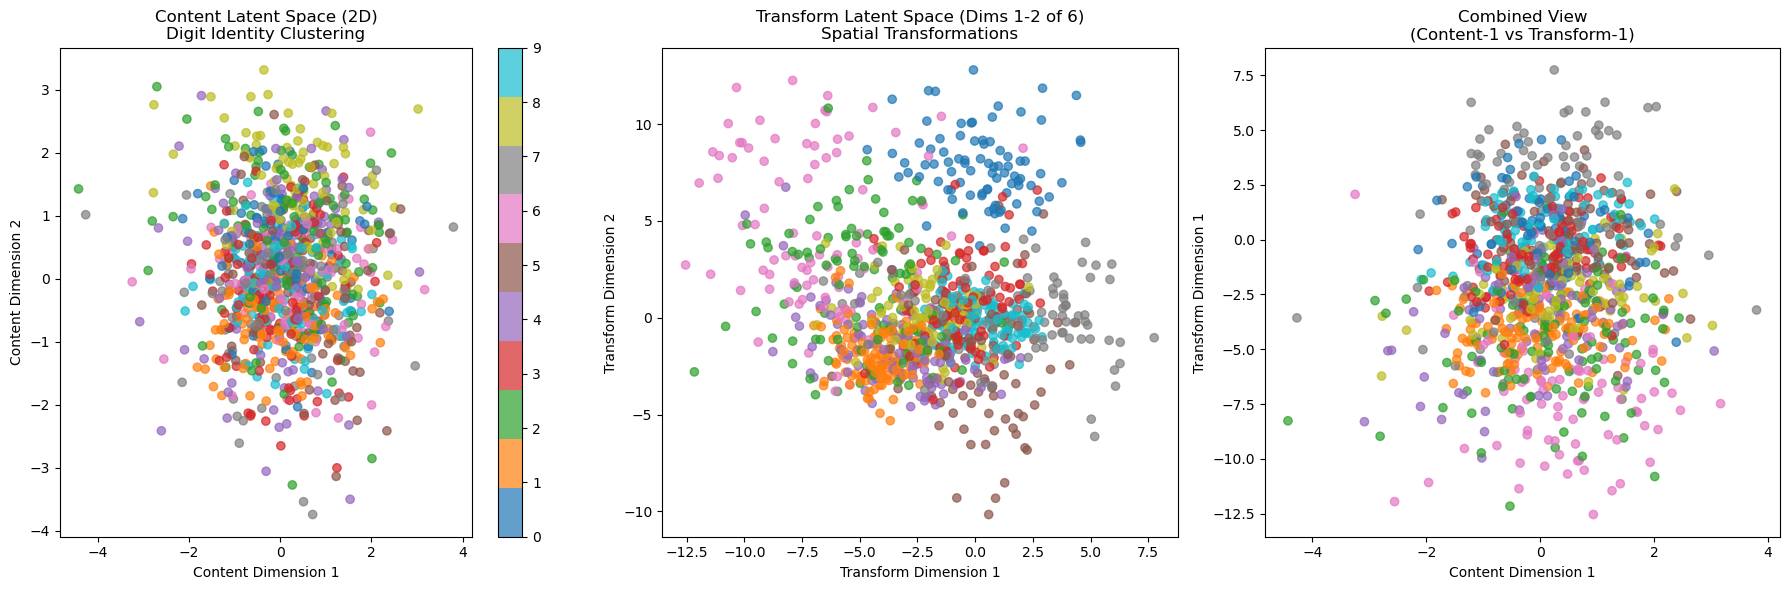

📊 Structured Latent Space Analysis:
  Content latent shape: (1000, 2)
  Transform latent shape: (1000, 6)
  Content variance: [1.0331327 1.1948079]
  Transform variance: [10.849209  13.393115  15.458089   6.0694904  9.542041   8.642452 ]


In [23]:
# 📈 VISUALIZE - Using explicit module references
s2d6d.plot_simplified_training_progress_structured(losses_dict)
content_data, transform_data, label_data = s2d6d.visualize_structured_latent_space(model, test_loader, device)

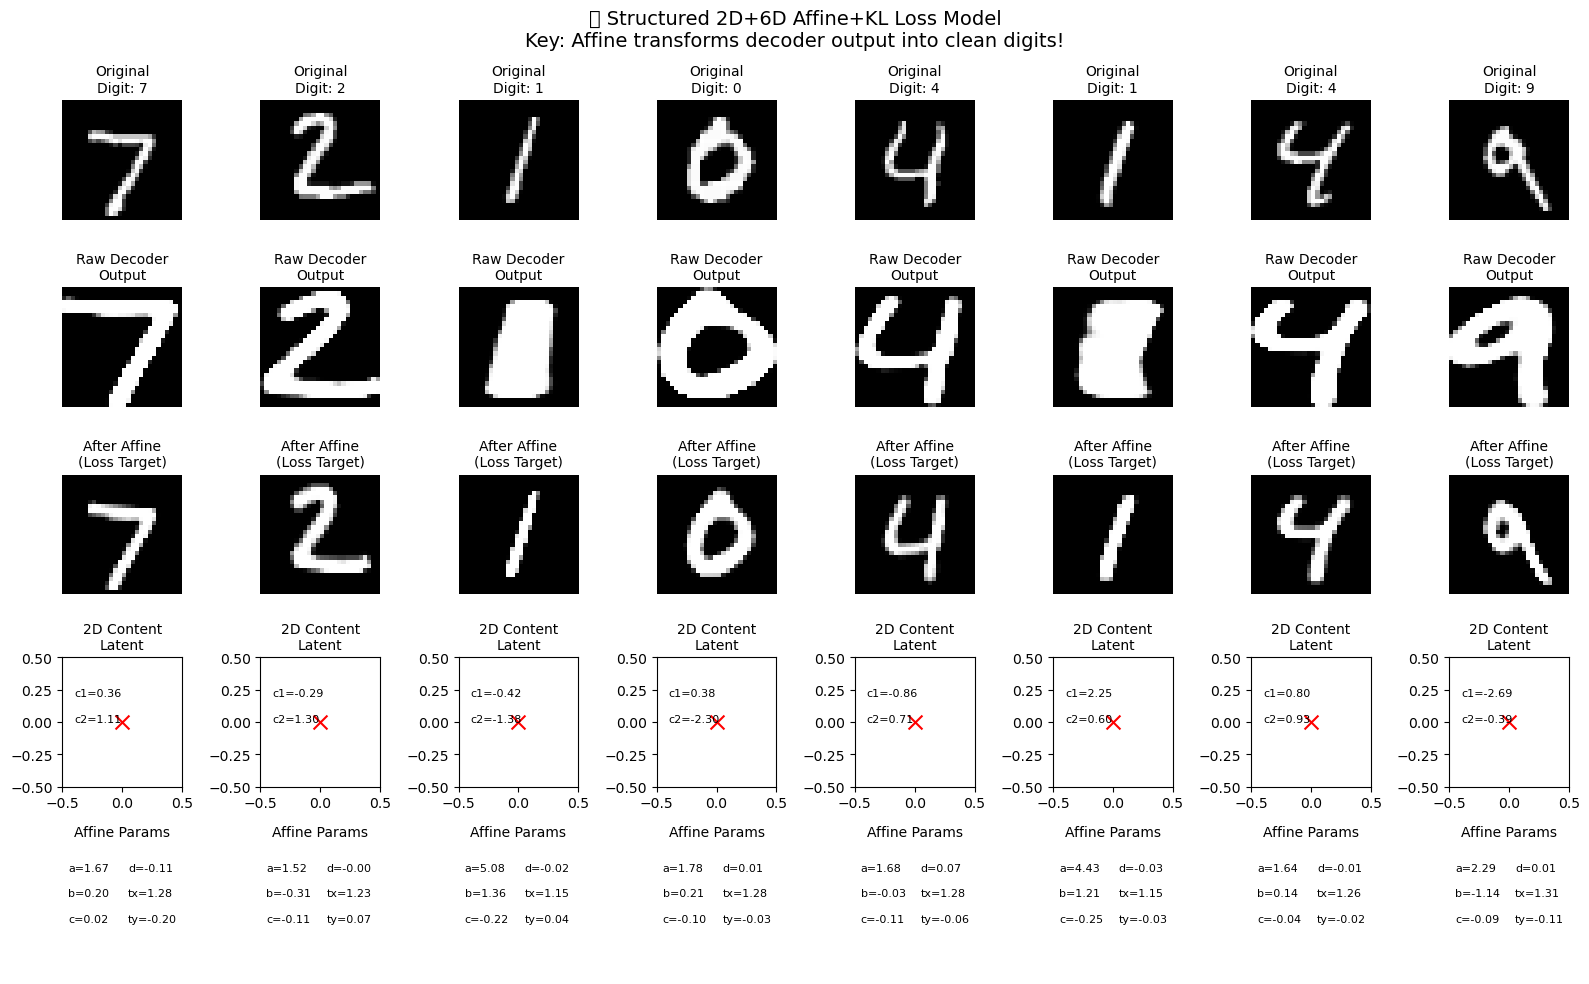


📊 Loss Analysis (Simplified Affine+KL Loss Function):
  Total Loss: 0.432903
  Reconstruction Loss (MSE after affine): 0.430932
  KL Divergence Loss (2D content latent): 1.970265
  Loss weights: α=1.0 (recon), β=0.001 (KL)

🎨 2D Content Latent Analysis:
  Content latent shape: torch.Size([8, 2])
  Content mu mean: [-0.14375865  0.1160157 ]
  Content mu std: [0.83372396 1.1628665 ]
  Content logvar mean: [-1.4486154 -2.1797516]

🔧 6D Transform Latent Analysis:
  Transform latent shape: torch.Size([8, 6])
  Transform mean: [-2.0025613  -0.41855752 -0.36037052  2.2260861   1.6866314  -1.4433018 ]
  Transform std: [3.816655  4.8811636 4.1525893 2.3639178 2.7703533 4.1944013]


In [25]:
# 🎨 COMPREHENSIVE VISUALIZATIONS - Using structured_2d6d_autoencoder module
s2d6d.comprehensive_visualization_structured(model, test_loader, device, CONFIG)

In [26]:
# 💾 SAVE - Using shared save functionality from affine_autoencoder_shared
# Basic save (model, config, losses only - no extra visualization data)
model_file, metadata_file = shared.save_model_cloud(model, CONFIG, losses_dict, device)

💾 Saved: autoencoder_model_20250721_014134.pth, autoencoder_metadata_20250721_014134.json


In [ ]:
# 💾 ALTERNATIVE: Save for Visualization (includes all data needed for viz)
# This saves everything needed to recreate visualizations later
# ✅ Updated to work with corrected model architecture
viz_filename = shared.save_model_for_viz(
    model, 
    model_type="structured_corrected",  # Updated model type to indicate corrected architecture
    config=CONFIG,
    losses=losses_dict,
    extra_data={
        'content_data': content_data,
        'transform_data': transform_data,
        'label_data': label_data,
        'config': CONFIG,
        'architecture_version': 'corrected_v2'  # Version flag for compatibility
    },
    name="2d6d_corrected"  # Updated name to reflect corrected architecture
)
print(f"💾 Model saved as: {viz_filename}")
print("🎯 This model uses the CORRECTED architecture with better digit clustering!")

💾 Saved structured model for visualization: structured_2d6d_simplified_20250721_014252.pth


In [11]:
#📁 LOAD MODEL FOR VISUALIZATION
#Run this cell to load a previously saved model instead of training from scratch
#NOTE: Fixed for PyTorch 2.6 weights_only issue

#Option 1: Load specific model by filename
model_path = 'structured_2d6d_simplified_20250721_013420.pth'
loaded_model, viz_data = shared.load_model_for_viz(model_path, 
                                                   s2d6d.StructuredAffineInvariantAutoEncoder, device)


📁 Loaded structured model from structured_2d6d_simplified_20250721_013420.pth
   Timestamp: 20250721_013420
   Device: cuda


In [18]:
viz_data.keys()

dict_keys(['config', 'losses', 'extra_data', 'timestamp', 'model_type', 'device'])

/home/exouser/Documents/adversAE/adversae/vae_training/affine/structured_2d6d_autoencoder.py:343: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/home/exouser/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


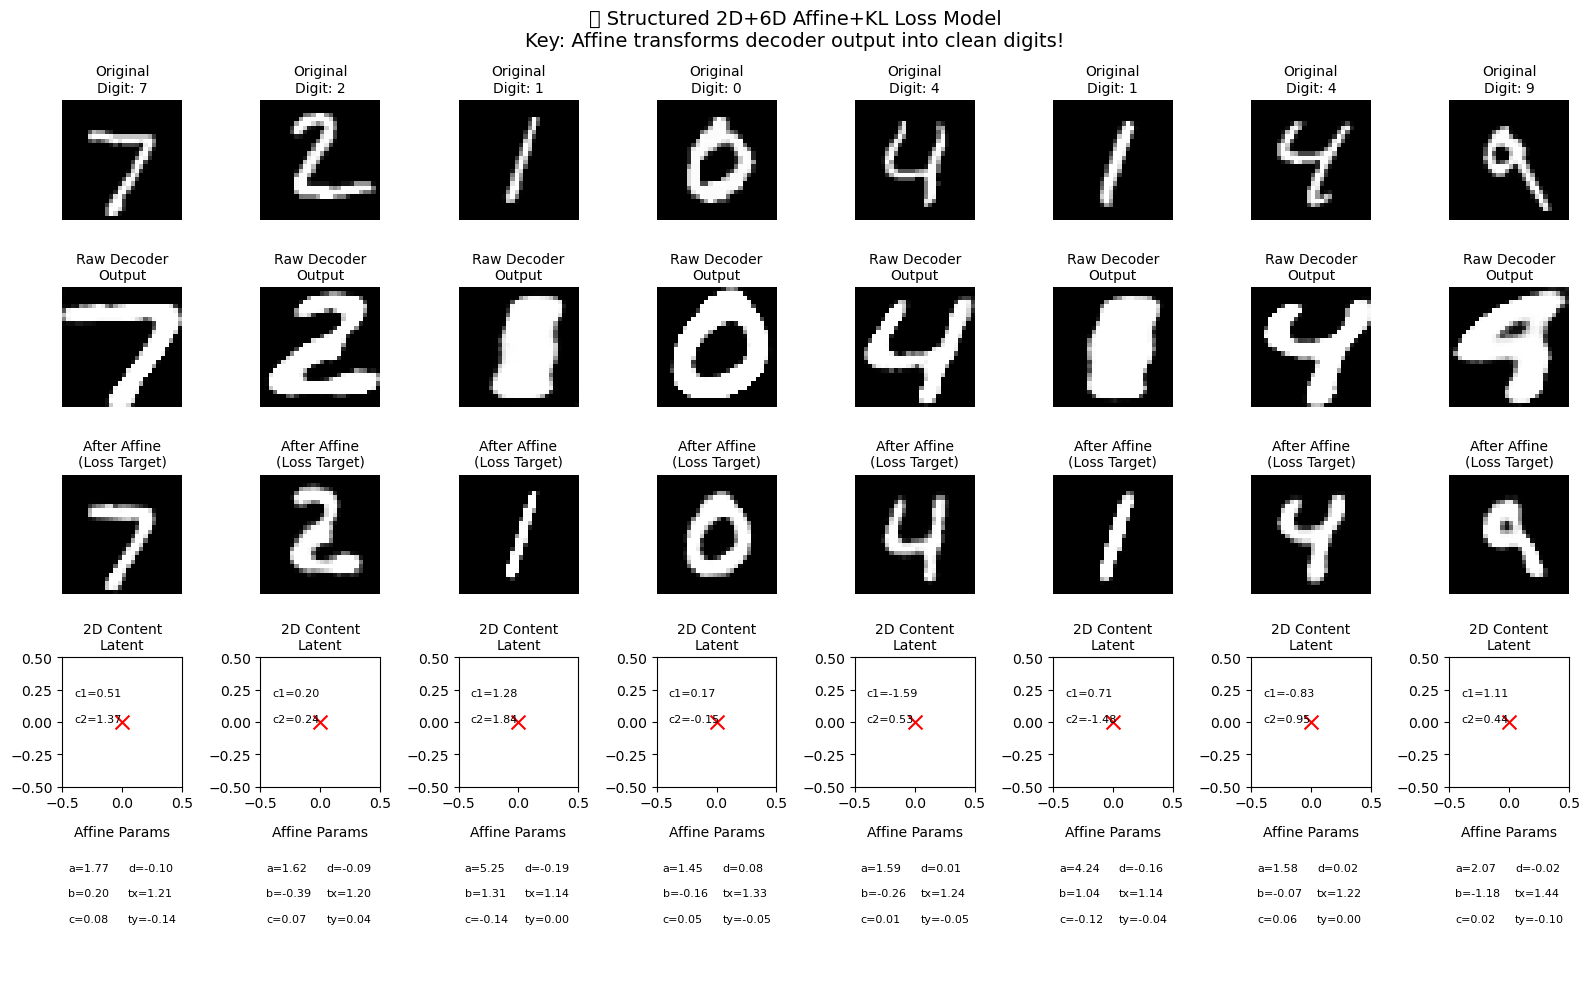


📊 Loss Analysis (Simplified Affine+KL Loss Function):
  Total Loss: 0.461004
  Reconstruction Loss (MSE after affine): 0.460158
  KL Divergence Loss (2D content latent): 0.846649
  Loss weights: α=1.0 (recon), β=0.001 (KL)

🎨 2D Content Latent Analysis:
  Content latent shape: torch.Size([8, 2])
  Content mu mean: [0.04174796 0.1323441 ]
  Content mu std: [0.674817   0.38179943]
  Content logvar mean: [-1.9465275 -0.2261337]

🔧 6D Transform Latent Analysis:
  Transform latent shape: torch.Size([8, 6])
  Transform mean: [-1.3637471  -1.4489424  -0.5418373  -2.2890437   2.6050673  -0.45559955]
  Transform std: [4.8383174 2.4993849 3.3657496 3.1386137 2.4901476 3.5223966]


In [12]:
s2d6d.comprehensive_visualization_structured(loaded_model, test_loader, device, CONFIG)

In [ ]:
# 📁 LOAD MODEL FOR VISUALIZATION
# Run this cell to load a previously saved model instead of training from scratch
# NOTE: Fixed for PyTorch 2.6 weights_only issue

# Option 1: Load specific model by filename
# model_path = '/path/to/your/structured_2d6d_simplified_20250720_123456.pth'
# loaded_model, viz_data = shared.load_model_for_viz(model_path, 
#                                                    s2d6d.StructuredAffineInvariantAutoEncoder, device)

# Option 2: Quick load most recent model
# loaded_model, viz_data = shared.quick_load_viz(s2d6d.StructuredAffineInvariantAutoEncoder, 
#                                                model_type="structured", name="2d6d_simplified", device=device)

# After loading, you can access:
# - loaded_model: The trained model ready for inference
# - viz_data['config']: Original training configuration  
# - viz_data['losses']: Training loss history
# - viz_data['extra_data']: Latent embeddings and other visualization data

# If you loaded a model, uncomment these lines to use it:
# model = loaded_model
# CONFIG = viz_data['config']
# losses_dict = viz_data['losses']
# if 'extra_data' in viz_data:
#     content_data = viz_data['extra_data'].get('content_data')
#     transform_data = viz_data['extra_data'].get('transform_data')
#     label_data = viz_data['extra_data'].get('label_data')

print("💡 Uncomment the lines above to load a saved model for visualization")